In [131]:
import numpy as np
import pandas as pd
import os
import tweepy as tw
import re
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.stem.porter import *
from sklearn.model_selection import train_test_split
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

pd.options.plotting.backend = "plotly"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [132]:
from google.colab import files
uploaded = files.upload()

Saving Twitter_Data.csv to Twitter_Data (1).csv


In [133]:
import sys
print(sys.version)


3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


In [134]:
import keras
import pickle

print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("Pickle version:", pickle.format_version)


TensorFlow version: 2.15.0
Keras version: 2.15.0
Pickle version: 4.0


In [135]:
df = pd.read_csv('Twitter_Data.csv')
df.head()

clean_text  category
0  when modi promised “minimum government maximum...      -1.0
1  talk all the nonsense and continue all the dra...       0.0
2  what did just say vote for modi  welcome bjp t...       1.0
3  asking his supporters prefix chowkidar their n...       1.0
4  answer who among these the most powerful world...       1.0

In [136]:
# Check for missing data
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [137]:
# drop missing rows
df.dropna(axis=0, inplace=True)

In [138]:
df.shape

(162969, 2)

In [139]:
df['category'] = df['category'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})
df.head()

clean_text  category
0  when modi promised “minimum government maximum...  Negative
1  talk all the nonsense and continue all the dra...   Neutral
2  what did just say vote for modi  welcome bjp t...  Positive
3  asking his supporters prefix chowkidar their n...  Positive
4  answer who among these the most powerful world...  Positive

In [140]:
# The distribution of sentiments
df.groupby('category').count().plot(kind='bar')

In [141]:
import plotly.express as px
fig = px.pie(df, names='category', title ='Pie chart of different sentiments of tweets')
fig.show()

**Plotting the distribution of tweet lengths**

In [142]:
# Calculate tweet lengths
tweet_len = pd.Series([len(tweet.split()) for tweet in df['clean_text']])

# The distribution of tweet text lengths
tweet_len.plot(kind='box')

**Plotting the distribution of text length for positive sentiment tweets**

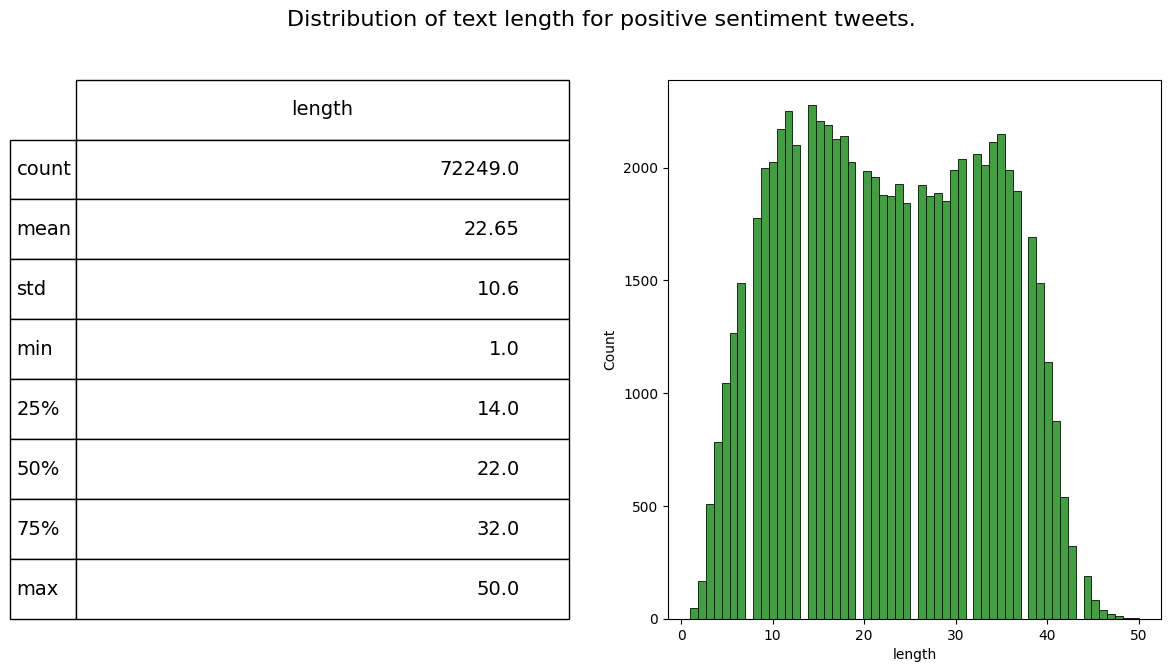

In [143]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Positive']['length'], ax=ax1,color='green')
describe = df.length[df.category=='Positive'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for positive sentiment tweets.', fontsize=16)

plt.show()

**Plotting the Distribution of text length for Negative sentiment tweets.**

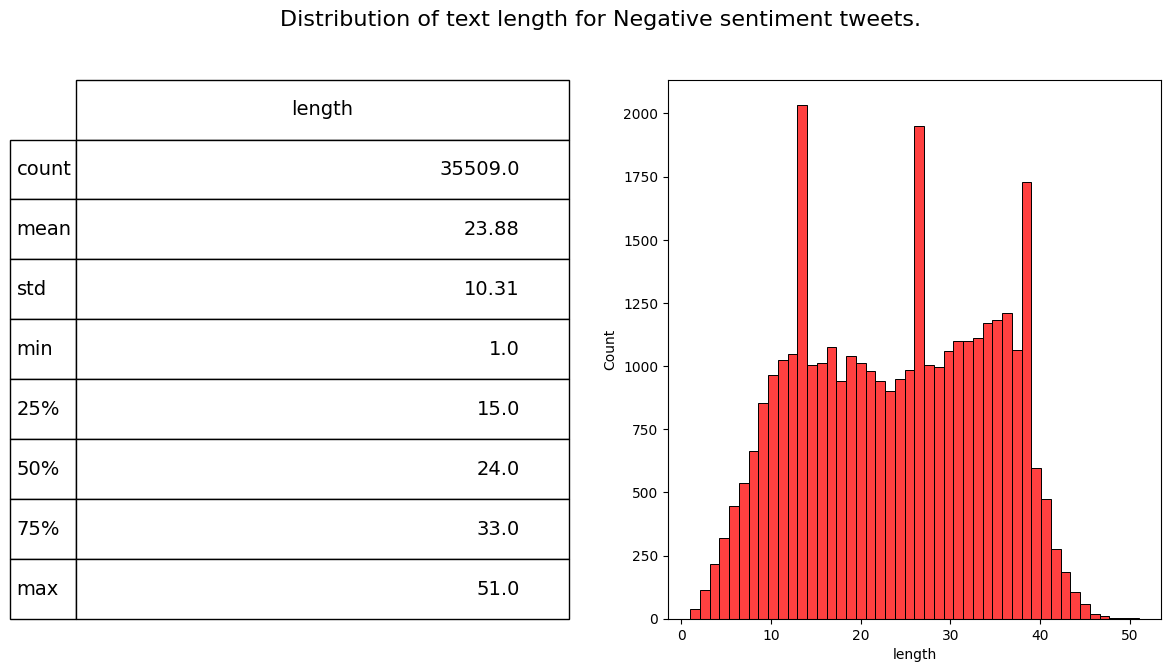

In [144]:
fig = plt.figure(figsize=(14,7))
df['length'] = df.clean_text.str.split().apply(len)
ax1 = fig.add_subplot(122)
sns.histplot(df[df['category']=='Negative']['length'], ax=ax1,color='red')
describe = df.length[df.category=='Negative'].describe().to_frame().round(2)

ax2 = fig.add_subplot(121)
ax2.axis('off')
font_size = 14
bbox = [0, 0, 1, 1]
table = ax2.table(cellText = describe.values, rowLabels = describe.index, bbox=bbox, colLabels=describe.columns)
table.set_fontsize(font_size)
fig.suptitle('Distribution of text length for Negative sentiment tweets.', fontsize=16)

plt.show()

**Plotting the Pie chart of the percentage of different sentiments of all the tweets**

In [145]:
df.drop(['length'], axis=1, inplace=True)
df.head

<bound method NDFrame.head of                                                clean_text  category
0       when modi promised “minimum government maximum...  Negative
1       talk all the nonsense and continue all the dra...   Neutral
2       what did just say vote for modi  welcome bjp t...  Positive
3       asking his supporters prefix chowkidar their n...  Positive
4       answer who among these the most powerful world...  Positive
...                                                   ...       ...
162975  why these 456 crores paid neerav modi not reco...  Negative
162976  dear rss terrorist payal gawar what about modi...  Negative
162977  did you cover her interaction forum where she ...   Neutral
162978  there big project came into india modi dream p...   Neutral
162979  have you ever listen about like gurukul where ...  Positive

[162969 rows x 2 columns]>

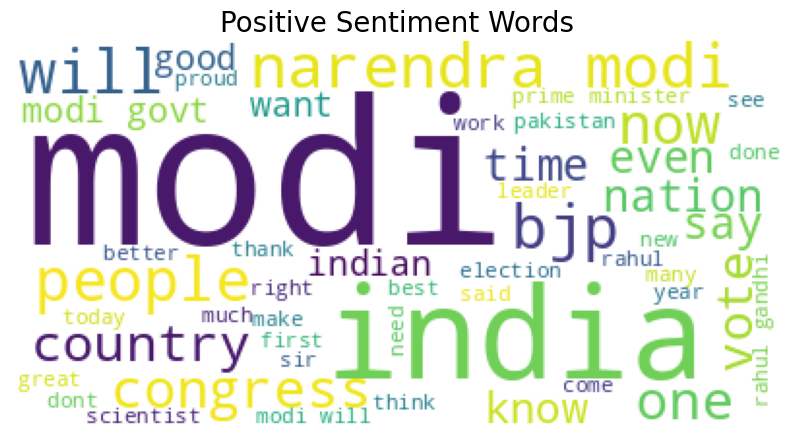

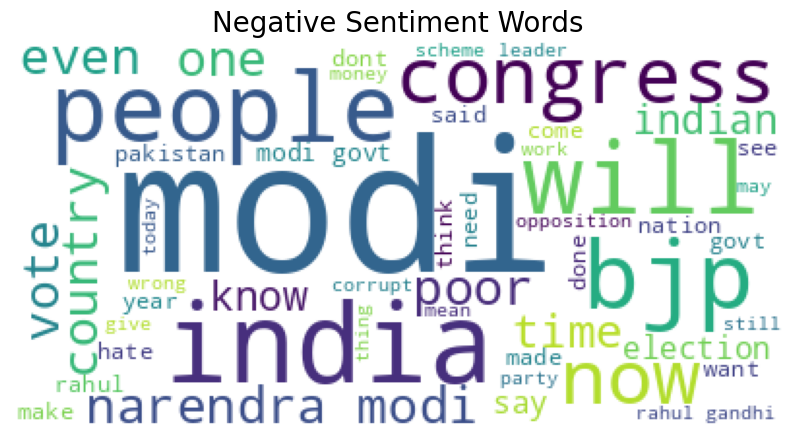

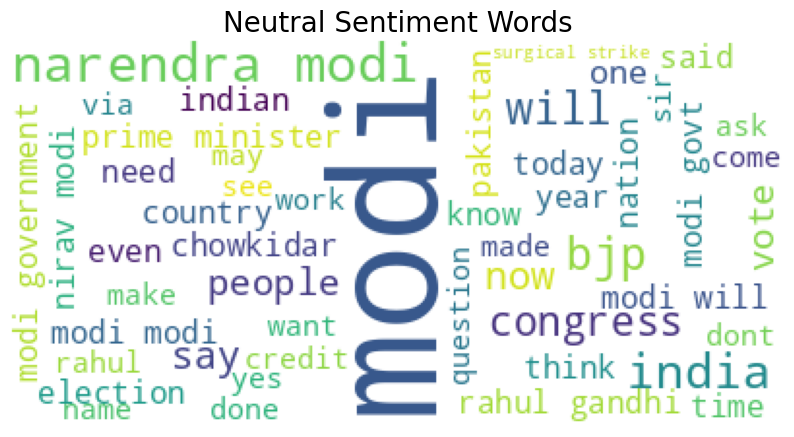

In [146]:

from wordcloud import WordCloud, STOPWORDS

def wordcount_gen(df, category):
    # Combine all tweets
    combined_tweets = " ".join([tweet for tweet in df[df.category==category]['clean_text']])


    wc = WordCloud(background_color='white',
                   max_words=50,
                   stopwords = STOPWORDS)


    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(combined_tweets))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()

# Positive tweet words
wordcount_gen(df, 'Positive')

# Negative tweet words
wordcount_gen(df, 'Negative')

# Neutral tweet words
wordcount_gen(df, 'Neutral')



In [147]:

# from nltk.stem import PorterStemmer
# from keras.preprocessing.text import Tokenizer
# stemmer = PorterStemmer()


# # Stemming the text
# stemmed_sentences = [' '.join([stemmer.stem(word) for word in sentence.split()]) for sentence in df['clean_text']]

In [148]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    X = tokenizer.texts_to_sequences(text)
    X = pad_sequences(X, padding='post', maxlen=max_len)
    return X, tokenizer

print('Before Tokenization & Padding \n', df['clean_text'][0])
X, tokenizer = tokenize_pad_sequences(df['clean_text'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 when modi promised “minimum government maximum governance” expected him begin the difficult job reforming the state why does take years get justice state should and not business and should exit psus and temples
After Tokenization & Padding 
 [  42    1  307   66 1726 1119   40 2378    2 1211  205    2  215   32
  155  100   49   69 1068  215   50    3    6  546    3   50 4179    3
 2806    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [149]:
y = pd.get_dummies(df['category'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (97781, 50) (97781, 3)
Validation Set -> (32594, 50) (32594, 3)
Test Set -> (32594, 50) (32594, 3)


In [150]:
import keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''

    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [151]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from keras.metrics import Precision, Recall
from keras.optimizers import SGD
from keras.optimizers import RMSprop
from keras import datasets

from keras.callbacks import LearningRateScheduler
from keras.callbacks import History

from keras import losses

vocab_size = 5000
embedding_size = 40
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = tf.keras.optimizers.legacy.SGD(learning_rate=learning_rate, momentum=momentum, decay=decay_rate)
model = Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32, return_sequences=True)))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(16)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

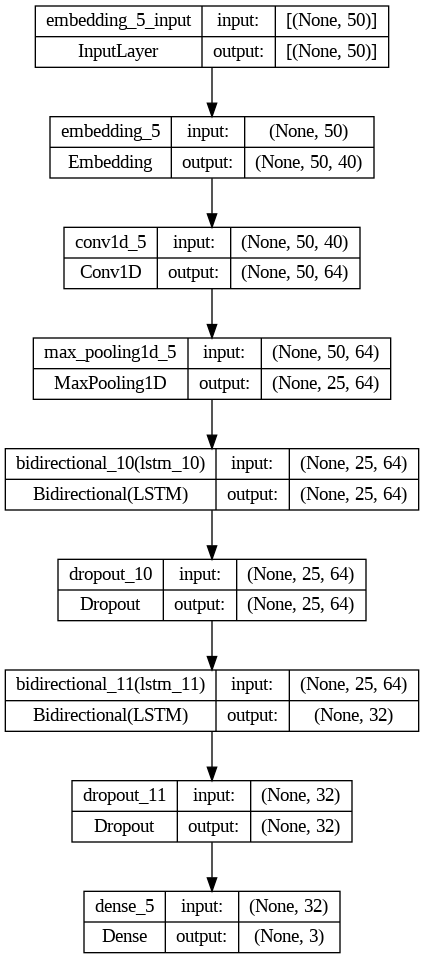

In [152]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [153]:
#Learning rate schedule function
def lr_schedule(epoch, lr):
    decay_rate = learning_rate / epochs
    lr *= 1.0 / (1.0 + decay_rate * epoch)
    return lr
lr_scheduler = LearningRateScheduler(lr_schedule)

In [154]:
print(model.summary())
model.compile(loss='categorical_crossentropy', optimizer=sgd,
               metrics=['accuracy', Precision(), Recall()])

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1,callbacks=[lr_scheduler]) #

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 50, 40)            200000    
                                                                 
 conv1d_5 (Conv1D)           (None, 50, 64)            7744      
                                                                 
 max_pooling1d_5 (MaxPoolin  (None, 25, 64)            0         
 g1D)                                                            
                                                                 
 bidirectional_10 (Bidirect  (None, 25, 64)            24832     
 ional)                                                          
                                                                 
 dropout_10 (Dropout)        (None, 25, 64)            0         
                                                                 
 bidirectional_11 (Bidirect  (None, 32)               

In [155]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)

print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.8856
Precision : 0.8867
Recall    : 0.8843
F1 Score  : 0.8855


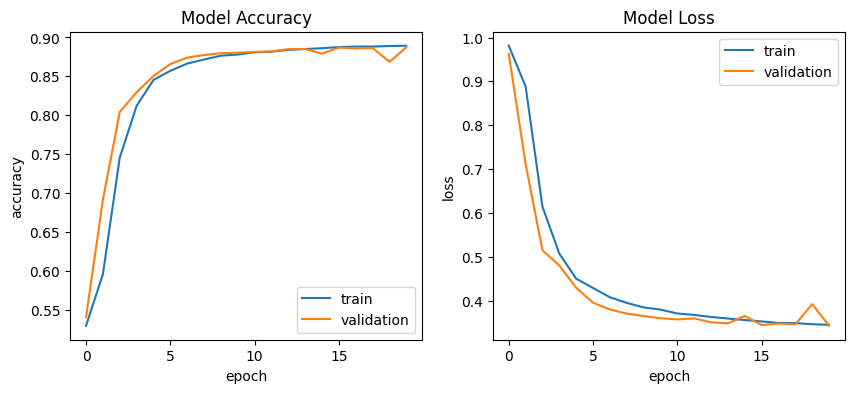

In [156]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''

    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')

plot_training_hist(history)

1019/1019 [==============================] - 13s 11ms/step


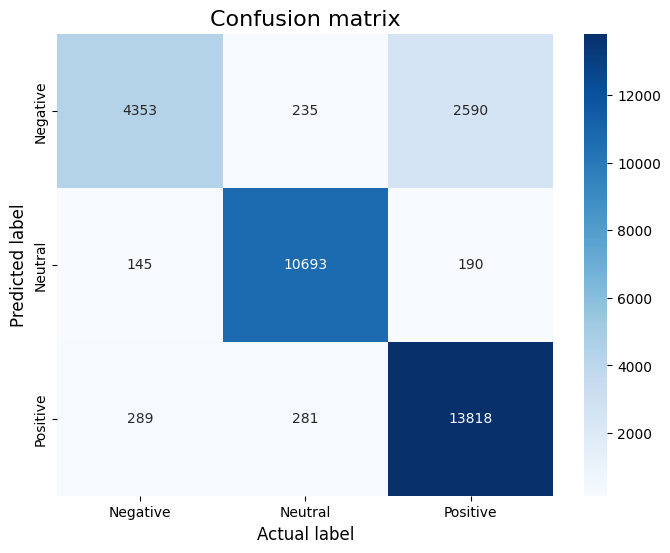

In [157]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    y_pred = model.predict(X_test)
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d',
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)

plot_confusion_matrix(model, X_test, y_test)

In [164]:
import pickle
with open('model.pickle', 'wb') as m:
    pickle.dump(model, m)

In [159]:
with open('tokenizer.pickle', 'wb') as m:
    pickle.dump(tokenizer, m)

In [160]:


def predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    xt = tokenizer.texts_to_sequences(text)
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    yt = model.predict(xt).argmax(axis=1)
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [161]:
predict_class(['"I hate when I have to call and wake people up'])

1/1 [==============================] - 0s 24ms/step
The predicted sentiment is Negative


In [162]:
predict_class(['The food was meh'])

1/1 [==============================] - 0s 24ms/step
The predicted sentiment is Neutral


In [163]:
predict_class(['He is good'])

1/1 [==============================] - 0s 23ms/step
The predicted sentiment is Positive


In [165]:
with open('model.pickle', 'rb') as f:
    # Load the object from the pickle file
    loaded_model = pickle.load(f)

In [166]:
with open('tokenizer.pickle', 'rb') as f:
    # Load the object from the pickle file
    loaded_tokenizer = pickle.load(f)

In [167]:
def loaded_predict_class(text):
    '''Function to predict sentiment class of the passed text'''

    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    xt = loaded_tokenizer.texts_to_sequences(text)
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    yt = loaded_model.predict(xt).argmax(axis=1)
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [169]:
loaded_predict_class(['I hate when I have to call and wake people up'])

1/1 [==============================] - 0s 72ms/step
The predicted sentiment is Negative
